In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/deeplabv3/tflite/default/1/1.tflite
/kaggle/input/military-camouflage-soldiers-dataset-mcs1k/dataset-splitM/Training/GT/image688.jpg
/kaggle/input/military-camouflage-soldiers-dataset-mcs1k/dataset-splitM/Training/GT/image233.jpg
/kaggle/input/military-camouflage-soldiers-dataset-mcs1k/dataset-splitM/Training/GT/image807.jpg
/kaggle/input/military-camouflage-soldiers-dataset-mcs1k/dataset-splitM/Training/GT/image427.jpg
/kaggle/input/military-camouflage-soldiers-dataset-mcs1k/dataset-splitM/Training/GT/image476.jpg
/kaggle/input/military-camouflage-soldiers-dataset-mcs1k/dataset-splitM/Training/GT/image571.jpg
/kaggle/input/military-camouflage-soldiers-dataset-mcs1k/dataset-splitM/Training/GT/image596.jpg
/kaggle/input/military-camouflage-soldiers-dataset-mcs1k/dataset-splitM/Training/GT/image848.jpg
/kaggle/input/military-camouflage-soldiers-dataset-mcs1k/dataset-splitM/Training/GT/image493.jpg
/kaggle/input/military-camouflage-soldiers-dataset-mcs1k/dataset-splitM/Train

In [2]:
import os
import numpy as np
import matplotlib.image as mpimg
import tensorflow as tf
import skimage as ski
#!pip install scikit-image
from tensorflow.keras.layers import Input, Conv2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from skimage.transform import resize



/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
def load_dataset(image_dir, gt_dir, target_size=(256, 256)):
    image_files = sorted([f for f in os.listdir(image_dir) if not f.startswith('.')])
    gt_files = sorted([f for f in os.listdir(gt_dir) if not f.startswith('.')])
    
    images = []
    annotations = []
    
    for fname in image_files:
        image_path = os.path.join(image_dir, fname)
        image = tf.io.read_file(image_path)
        image = tf.image.decode_image(image, channels=3)
        image = tf.image.resize(image, target_size)
        image = tf.cast(image, tf.float32) / 255.0
        images.append(image.numpy())

    for fname in gt_files:
        gt_path = os.path.join(gt_dir, fname)
        annotation = tf.io.read_file(gt_path)
        annotation = tf.image.decode_image(annotation, channels=1)
        annotation = tf.image.resize(annotation, target_size)
        annotation = tf.cast(annotation, tf.float32) / 255.0
        annotations.append(annotation.numpy())
    
    return images, annotations

def convert_rgba_to_binary_mask(annotations):
    binary_masks = [np.where(annotation > 0.5, 1, 0) for annotation in annotations]
    return binary_masks


In [4]:
TRAIN_IMAGE_DIR = "/kaggle/input/military-camouflage-soldiers-dataset-mcs1k/dataset-splitM/Training/images"
TRAIN_GT_DIR = "/kaggle/input/military-camouflage-soldiers-dataset-mcs1k/dataset-splitM/Training/GT"
TEST_IMAGE_DIR = "/kaggle/input/military-camouflage-soldiers-dataset-mcs1k/dataset-splitM/Testing/images"
TEST_GT_DIR = "/kaggle/input/military-camouflage-soldiers-dataset-mcs1k/dataset-splitM/Testing/GT"

train_images, train_annotations = load_dataset(TRAIN_IMAGE_DIR, TRAIN_GT_DIR)
train_masks = convert_rgba_to_binary_mask(train_annotations)
test_images, test_annotations = load_dataset(TEST_IMAGE_DIR, TEST_GT_DIR)
test_masks = convert_rgba_to_binary_mask(test_annotations)


In [5]:
from tensorflow.keras.layers import Input, Conv2D, Dropout, UpSampling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2

def create_deeplabv3plus(input_shape):
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet', alpha=1.0)
    base_model.trainable = True  # Fine-tune the base model

    # Get the output of the last layer in the base model
    x = base_model.output

    # The output size depends on the base model. Ensure the upsampling matches the target size.
    # Upsample the output of the base model to the correct dimensions.
    x = UpSampling2D(size=(4, 4))(x)  # Upsample from base output size to intermediate size
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = UpSampling2D(size=(4, 4))(x)  # Upsample to intermediate size
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = UpSampling2D(size=(2, 2))(x)  # Upsample to target size
    x = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)

    # Create the model
    model = Model(inputs=base_model.input, outputs=x)
    
    return model

# Now you can create a model instance with the desired input shape.
input_shape = (256, 256, 3)  # Assuming the input images are 256x256x3
model = create_deeplabv3plus(input_shape)



9406464/9406464 [==============================] - 0s 0us/step


In [6]:
# Check the model summary to confirm the output shape
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 128, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 128, 128, 32  128         ['Conv1[0][0]']                  
                                )                                                             

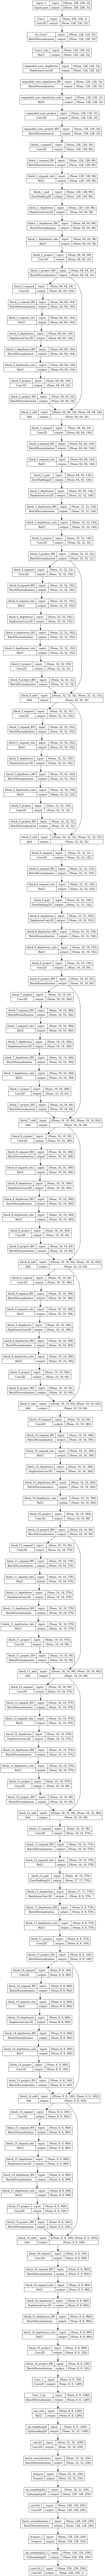

In [7]:

from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
from IPython.display import Image

# Display the image in Jupyter
Image('model.png')


In [17]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=3,          # Stop training after 3 epochs without improvement in validation loss
    verbose=1,           # Print a message when stopping
    restore_best_weights=True  # Restore model weights from the epoch with the best validation loss
)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model with the early stopping callback
history = model.fit(
    np.array(train_images),
    np.array(train_masks),
    batch_size=8,
    epochs=50,  # Set to a higher number, as early stopping will interrupt the training
    validation_split=0.1,
    callbacks=[early_stopping]  # Include the early stopping callback here
)

# Evaluate the model
loss, accuracy = model.evaluate(np.array(test_images), np.array(test_masks))
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


Epoch 1/50


2023-11-09 10:38:39.068185: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


85/85 [==============================] - 42s 149ms/step - loss: 0.3412 - accuracy: 0.8746 - val_loss: 11.0400 - val_accuracy: 0.3888
Epoch 2/50
85/85 [==============================] - 11s 126ms/step - loss: 0.3060 - accuracy: 0.8825 - val_loss: 2.2082 - val_accuracy: 0.3282
Epoch 3/50
85/85 [==============================] - 11s 125ms/step - loss: 0.2710 - accuracy: 0.8916 - val_loss: 2.1201 - val_accuracy: 0.7792
Epoch 4/50
85/85 [==============================] - 11s 126ms/step - loss: 0.2196 - accuracy: 0.9107 - val_loss: 1.9433 - val_accuracy: 0.7655
Epoch 5/50
85/85 [==============================] - 11s 126ms/step - loss: 0.2210 - accuracy: 0.9139 - val_loss: 0.9381 - val_accuracy: 0.8177
Epoch 6/50
85/85 [==============================] - 11s 125ms/step - loss: 0.2673 - accuracy: 0.8914 - val_loss: 1.1987 - val_accuracy: 0.8327
Epoch 7/50
85/85 [==============================] - 11s 125ms/step - loss: 0.2120 - accuracy: 0.9137 - val_loss: 8.7214 - val_accuracy: 0.4479
Epoch 8/5

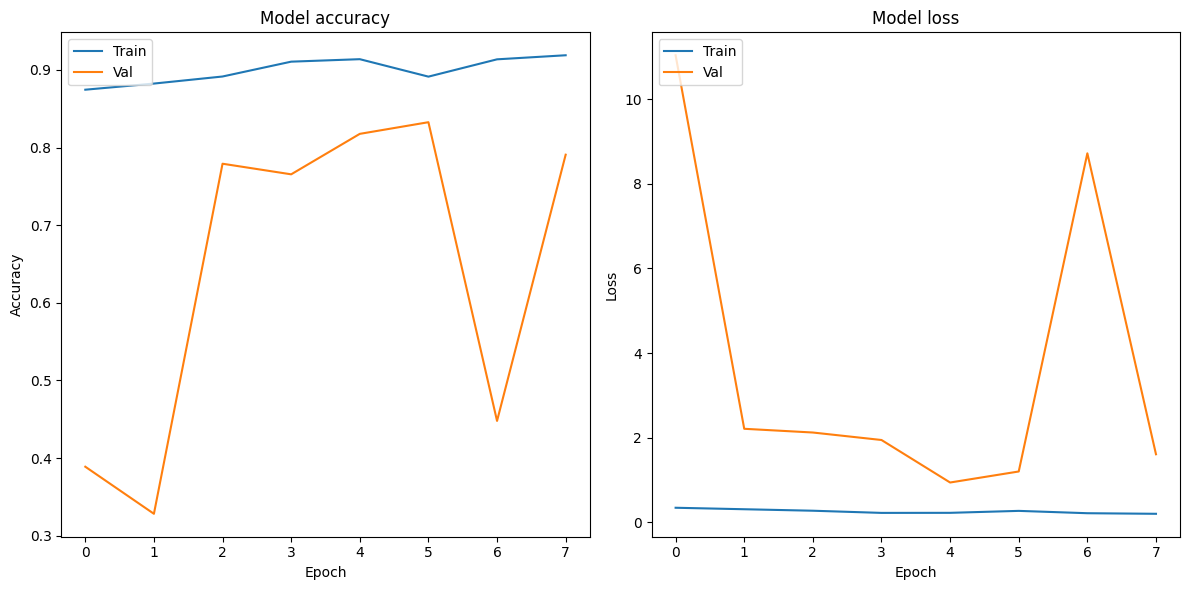

In [18]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
plt.show()

11/11 [==============================] - 1s 114ms/step


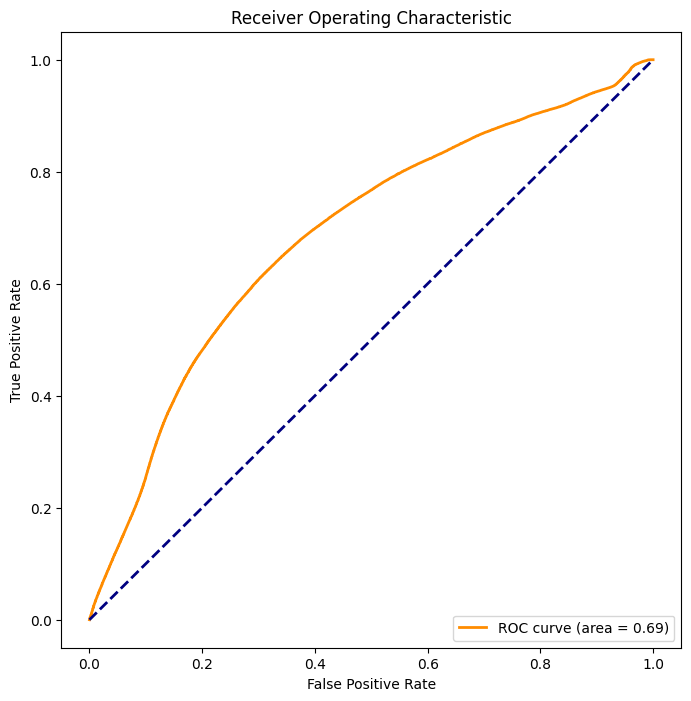

In [21]:
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# Assuming you have a binary classification problem
# Get predictions
predictions = model.predict(np.array(test_images))
predicted_classes = (predictions > 0.5).astype(int)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(np.array(test_masks).reshape(-1), predictions.reshape(-1))
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


In [23]:
loss, accuracy = model.evaluate(np.array(test_images), np.array(test_masks))
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")



11/11 [==============================] - 1s 115ms/step - loss: 0.6227 - accuracy: 0.7208
Test Loss: 0.6227
Test Accuracy: 0.7208


11/11 [==============================] - 1s 113ms/step - loss: 0.6227 - accuracy: 0.7208
Test Loss: 0.6227
Test Accuracy: 0.7208


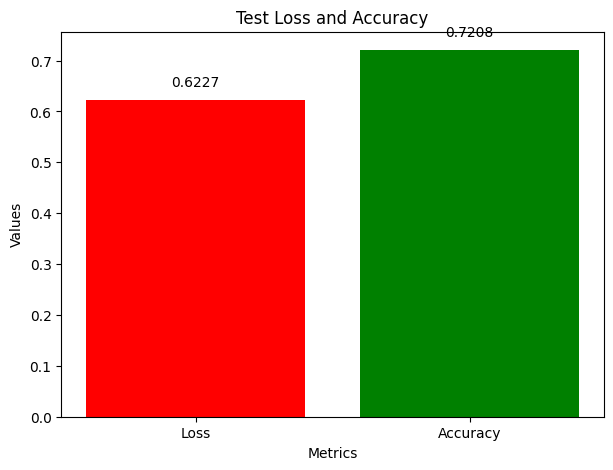

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have the test_images and test_masks as numpy arrays
test_images = np.array(test_images)
test_masks = np.array(test_masks)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_images, test_masks)

# Print out the loss and accuracy
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Create bar plot for loss and accuracy
metrics = ['Loss', 'Accuracy']
values = [loss, accuracy]

plt.figure(figsize=(7, 5))
plt.bar(metrics, values, color=['red', 'green'])
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Test Loss and Accuracy')
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.4f}", ha='center', va='bottom')

plt.show()

In [22]:
# Commenting as model already saved as model1.h5
'''
# Save the model
model1= "model1.h5"

# Save the model
model.save(model1)
'''